In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import umap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ten

In [2]:

cpdir = 'Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/'
checkpoint = 'best-checkpoint-21300'
if not cpdir.endswith('/'):
    cpdir += '/'

In [3]:
sval = cpdir.split("/")
valdir = "/".join(sval[0:-2]) + "/"
val_images = np.load(valdir + 'validation_images.npy')
val_labels = np.load(valdir + 'validation_labels.npy')
val_nums = val_labels.argmax(axis=1)

In [4]:
### load the Image 3C clusters into a dataframe
df = pd.read_csv('Data/Snail/ClusterIDs.csv')
#print(df.head())

# map classes to zero based ids
rmin = df.ClusterID.min()
rmax = df.ClusterID.max()
rmap = {}
for i, rc in enumerate(np.arange(rmin, rmax + 1, 1)):
    rmap[rc] = i
    
df['Image3C_Cluster'] = df.ClusterID.map(rmap)
### read in the fdl coordinates, not all of the cells have fdl coords
fdl = pd.read_csv('Data/Snail/FDL_coords.csv', delimiter=';')
fdl['Y'] = -fdl['Y']
#print(fdl.head())

### join the fdl and df for a dataframe

#res.head()


In [5]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "orange", "yellow", "green"]
#sns.palplot(sns.color_palette(flatui))

def scatter(df, hue=None,legend_title=None):

    #hue = 'Image3C_Cluster'
    fig =plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    g = sns.scatterplot(x='X', y='Y', hue=hue, s=4,
                    alpha=.9, edgecolor=None,
                    palette='Set1',
                    legend='full', data=df, ax=ax)

    plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1), frameon=False)

       
    

In [6]:
mm_images = np.memmap('Data/images.mm', dtype=np.float32, mode='r')
images = mm_images.reshape((-1, 64, 64, 5))
images = images[:,16:48,16:48,[0,2,4]]
del mm_images
images.shape

(35469, 32, 32, 3)

In [7]:
mm_labels = np.memmap('Data/labels.mm', dtype=np.float32, mode='r')
labels = mm_labels.reshape((images.shape[0], -1))
del mm_labels
labels.shape

(35469, 9)

In [8]:
def combine_classes(c1, c2, labels):
        nc = labels.shape[1]
        v1 = np.zeros((nc,), dtype=np.float32)
        v2 = np.zeros((nc,), dtype=np.float32)

        v1[c1] = 1.
        v2[c2] = 1.
        cx = labels.argmax(axis=1)

        wx1 = np.where(cx == c1)
        wx2 = np.where(cx == c2)
        new_labels = labels.copy()
        new_labels[wx2] = v1
        new_labels = np.delete(new_labels, c2, 1)

        return new_labels
    
nlbl = combine_classes(0, 8, labels)
nlbl = combine_classes(4, 7,nlbl)
labels =nlbl

df['Image3C_Cluster'] = labels.argmax(axis=1)

In [9]:
imean = images.mean(axis=(1,2), keepdims=True)
istd = images.std(axis=(1,2), keepdims=True)
images =(images - imean)/istd

In [10]:
len(df)
#cpdir = 'Checkpoints/Snail_Redo_for_metrics/best-2019-08-16-09-02/'
#checkpoint = 'best-checkpoint-10800'

35469

In [11]:
sess = tf.Session()
saver = tf.train.import_meta_graph(cpdir + checkpoint + '.meta')
saver.restore(sess, cpdir + checkpoint)

softmax = sess.graph.get_tensor_by_name('Softmax:0')
batch = sess.graph.get_tensor_by_name('Placeholder:0')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/best-checkpoint-21300


In [12]:
vsm = sess.run(softmax, feed_dict={batch:images})
vsm_nums = vsm.argmax(axis=1)

df['predicted'] = vsm_nums

In [13]:
nums = labels.argmax(axis=1)

metrics.accuracy_score(nums, vsm_nums), metrics.accuracy_score(nums, df['Image3C_Cluster'])


(0.7749866080239082, 1.0)

In [14]:
print(metrics.classification_report(nums, vsm_nums))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     19450
           1       0.49      0.73      0.59      1729
           2       0.52      0.69      0.60      2015
           3       0.72      0.78      0.75      4899
           4       0.53      0.73      0.62      1143
           5       0.63      0.65      0.64      3152
           6       0.65      0.56      0.60      3081

   micro avg       0.77      0.77      0.77     35469
   macro avg       0.64      0.71      0.67     35469
weighted avg       0.80      0.77      0.78     35469



In [15]:
max_sm = vsm.max(axis=1)
df['max_sm'] = max_sm

In [16]:
df['match'] = df.predicted == df['Image3C_Cluster']

In [17]:
def cbin(x):
    return(int(10*x)/10)

df['cbin'] = df.max_sm.map(cbin)

In [18]:
res = fdl.set_index('EventID').join(df.set_index('EventID'))

<Figure size 576x576 with 0 Axes>

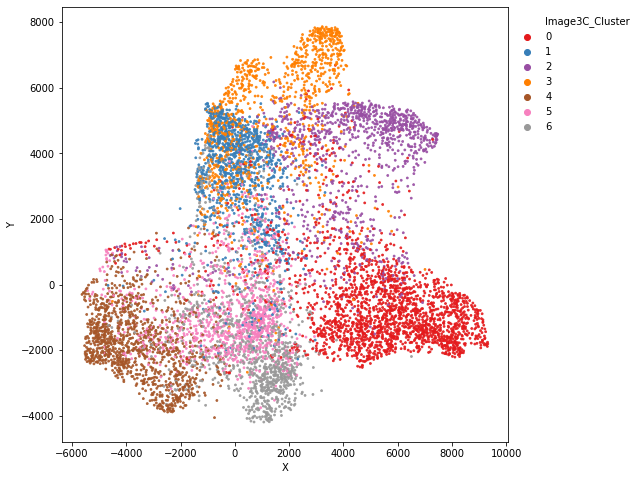

In [19]:
plt.figure(figsize=(8,8))
scatter(res, hue='Image3C_Cluster', legend_title="Image 3C Cluster")
#plt.savefig('C7-plots/image3c_clusters.svg', bbox_inches='tight')

<Figure size 576x576 with 0 Axes>

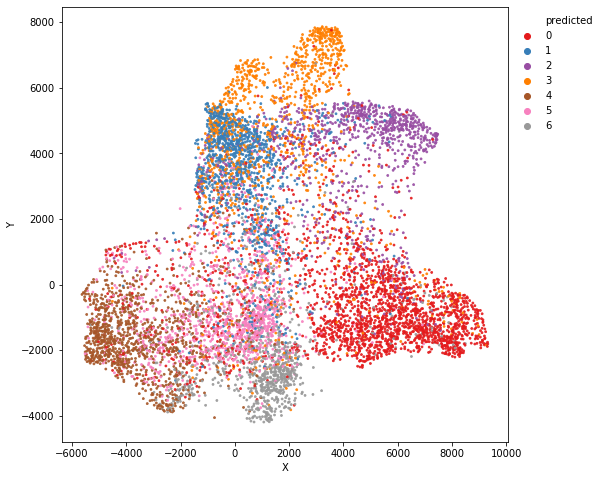

In [20]:
plt.figure(figsize=(8,8))
scatter(res, hue='predicted')
#plt.savefig('C7-plots/predicted.svg', bbox_inches='tight')

In [21]:
res0 = res[res.max_sm > .8]
resx = res[res.max_sm < .5]
len(res0), len(resx)

(3423, 1475)

In [ ]:
scatter(res0, hue='predicted')
plt.savefig('C7-plots/predicted_high_prob.svg', bbox_inches='tight')

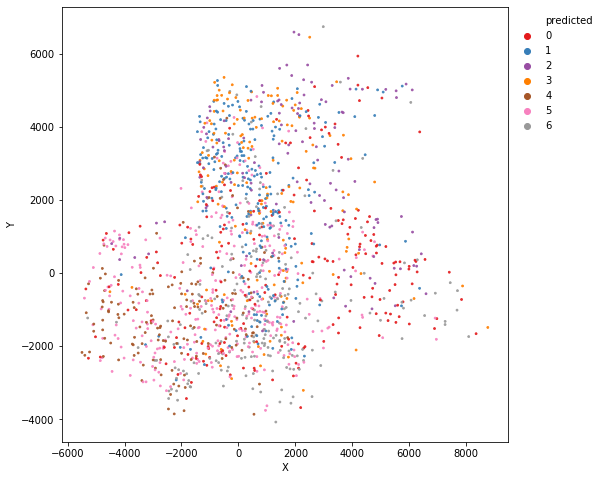

In [22]:
scatter(resx, hue='predicted')
#plt.savefig('C7-plots/predicted_low_prob.svg', bbox_inches='tight')

[0.7 0.6 0.9 0.2 0.5 0.8 0.3 0.4]


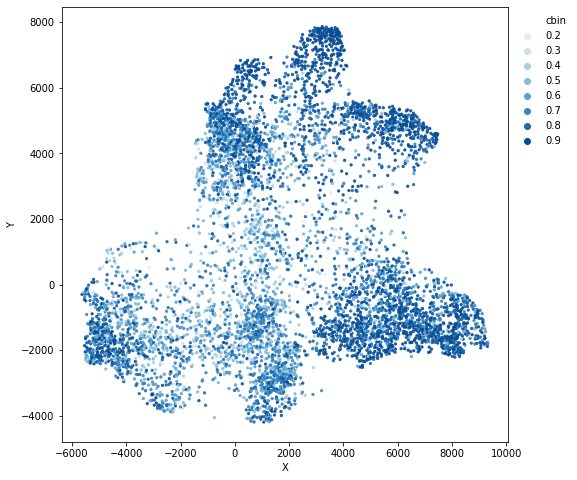

In [23]:
fig =plt.figure(figsize=(8,8))
print(res[res.match == True].cbin.unique())
sns.scatterplot(x='X', y='Y', hue='cbin',s=6, #size='max_sm',
                data=res[res.match == True], alpha=.9, legend='full',
                palette=sns.color_palette("Blues", len(res.cbin.unique())),
                edgecolor=None)

plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1), frameon=False)
#plt.savefig('C7-plots/matched_true_prob.svg', bbox_inches='tight')

[0.4 0.5 0.3 0.8 0.6 0.7 0.9 0.2]


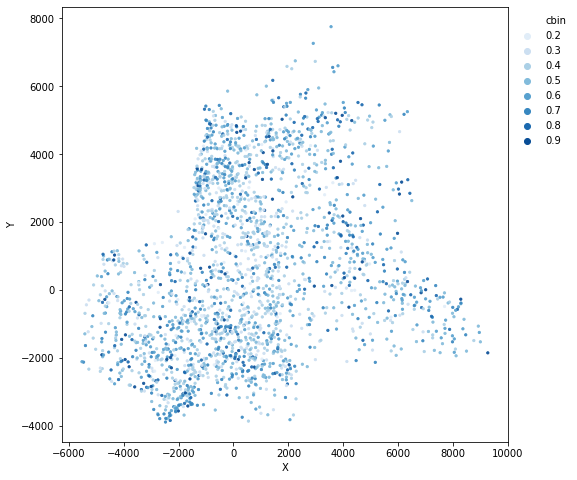

In [24]:
fig =plt.figure(figsize=(8,8))
print(res[res.match == False].cbin.unique())
sns.scatterplot(x='X', y='Y', hue='cbin',s=6, #size='max_sm',
                data=res[res.match == False], alpha=.9, legend='full',
                palette=sns.color_palette("Blues", len(res.cbin.unique())),
                edgecolor=None)

plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1), frameon=False)
#plt.savefig('C7-plots/matched_false_prob.svg', bbox_inches='tight')

[0.7 0.6 0.9 0.2 0.5 0.8 0.3 0.4]


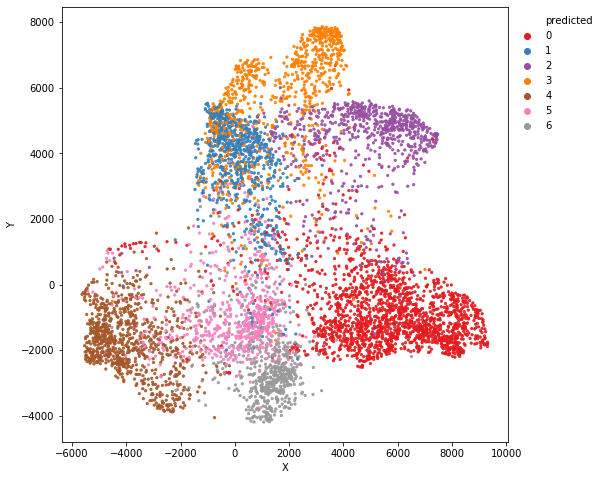

In [25]:
fig =plt.figure(figsize=(8,8))
print(res[res.match == True].cbin.unique())
sns.scatterplot(x='X', y='Y', hue='predicted',s=6, #size='max_sm',
                data=res[res.match == True], alpha=.9, legend='full',
                palette='Set1',
                edgecolor=None)

plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1), frameon=False)
#plt.savefig('C7-plots/matched_true_class.svg', bbox_inches='tight')

[0.4 0.5 0.3 0.8 0.6 0.7 0.9 0.2]


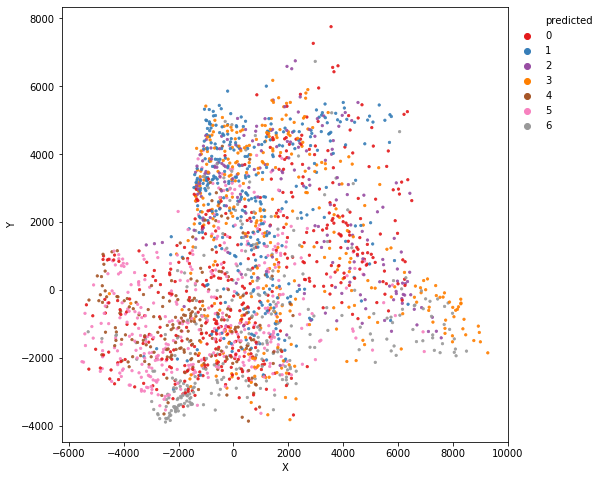

In [26]:
fig =plt.figure(figsize=(8,8))
print(res[res.match == False].cbin.unique())
sns.scatterplot(x='X', y='Y', hue='predicted',s=6, #size='max_sm',
                data=res[res.match == False], alpha=.9, legend='full',
                palette='Set1',
                edgecolor=None)

plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1), frameon=False)
#plt.savefig('C7-plots/matched_false_class.svg', bbox_inches='tight')

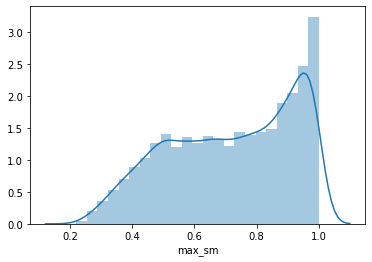

In [27]:
sns.distplot(res.max_sm)

In [ ]:
testlossdf = pd.read_csv('Loss_acc_plots/Snail7/run-test-tag-loss.csv')
trainlossdf = pd.read_csv('Loss_acc_plots/Snail7/run-train-tag-loss.csv')
testaccdf = pd.read_csv('Loss_acc_plots/Snail7/run-test-tag-accuracy_1.csv')
trainaccdf = pd.read_csv('Loss_acc_plots/Snail7/run-train-tag-accuracy_1.csv')

In [ ]:
plt.plot(trainlossdf['Step'], trainlossdf['Value'], label="Training", color='C0')
plt.plot(testlossdf['Step'], testlossdf['Value'], label="Test", color='C1')

plt.xlim(-500, 25000)
plt.xlabel("Iteration step")
plt.ylabel("Loss")
legend = plt.legend(loc='upper left', prop={'size':10},
                    bbox_to_anchor=(.25,1), framealpha=0.0)
sns.despine()
plt.savefig('C7-plots/training_loss.svg', bbox_inches='tight')

In [ ]:
plt.plot(trainaccdf['Step'], trainaccdf['Value'], label='Training', color='C0')
plt.plot(testaccdf['Step'], testaccdf['Value'], label='Test', color='C1')

plt.xlim(-500, 25000)
plt.xlabel("Iteration step")
plt.ylabel("Accuracy")
plt.legend(framealpha=0.0)
sns.despine()
plt.savefig('C7-plots/training_accuracy.svg', bbox_inches='tight')